In [1]:
from __future__ import print_function, division
%matplotlib inline
import statsmodels.formula.api as smf  
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import operator
import requests
import sys
import operator
from scipy import stats
from fiona.crs import from_epsg

In [2]:
matplotlib.style.use('seaborn-pastel')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,10)

In [3]:
#nyc open data API, you need apptoken to run this cell
from sodapy import Socrata
client = Socrata("data.cityofnewyork.us", os.getenv("apptoken"))

In [4]:
results = client.get("rjkj-7qni",
                     select = "postcode, boiler_installation_date, total_estimated_cosumption_high_estimate_gallons_, latitude, longitude",
                     limit=20000)
df = pd.DataFrame.from_records(results)
df.head()

,boiler_installation_date,latitude,longitude,postcode,total_estimated_cosumption_high_estimate_gallons_
0,1992,NaN,NaN,NaN,131400
1,2003,NaN,NaN,NaN,39938
2,1988,40.85019,-73.91403,10453,49275
3,2001,NaN,NaN,NaN,57488
4,1980,NaN,NaN,NaN,75130


In [5]:
df.shape

(8048, 5)

In [6]:
df['boiler_installation_date'] = pd.to_numeric(df['boiler_installation_date'], errors='coerce')
df= df[df['boiler_installation_date']<2015]

In [7]:
df.count()

boiler_installation_date                             8048
latitude                                             4857
longitude                                            4857
postcode                                             4857
total_estimated_cosumption_high_estimate_gallons_    8048
dtype: int64

In [8]:
df.to_csv('boiler_query.csv')

In [9]:
df.dtypes

boiler_installation_date                              int64
latitude                                             object
longitude                                            object
postcode                                             object
total_estimated_cosumption_high_estimate_gallons_    object
dtype: object

In [10]:
df.rename(columns={'boiler_capacity_gross_btu_': 'boiler_capacity',
                      'postcode': 'zip_code',
                      'total_estimated_cosumption_high_estimate_gallons_': 'total_consumption_gallons'}, inplace=True)

In [11]:
df['total_consumption_gallons'] = pd.to_numeric(df['total_consumption_gallons'], errors='coerce')

In [12]:
df.dtypes

boiler_installation_date      int64
latitude                     object
longitude                    object
zip_code                     object
total_consumption_gallons     int64
dtype: object

In [13]:
df = df.dropna(subset=['zip_code'])

In [14]:
len(df)

4857

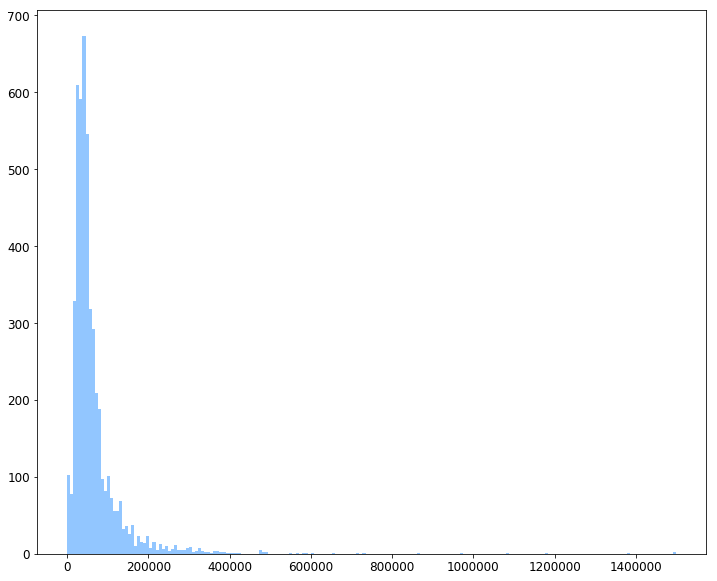

In [15]:
plt.hist(df['total_consumption_gallons'], bins=200)
plt.show()

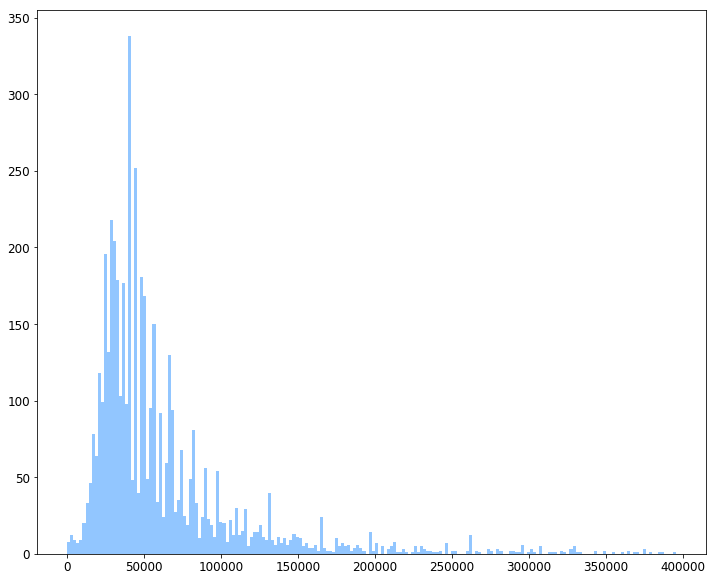

In [16]:
df = df[df['total_consumption_gallons']>0]
df = df[df['total_consumption_gallons']<400000]
plt.hist(df['total_consumption_gallons'], bins=200)
plt.show()

In [17]:
len(df)

4760

In [18]:
dfzip = df.groupby("zip_code").sum()
dfzip.reset_index(inplace=True)

In [19]:
dfzip.to_csv('boiler_estimate_cosumption_2015_byzipcode.csv')

In [20]:
type(dfzip)

pandas.core.frame.DataFrame

In [21]:
os.system("curl -O http://catalog.civicdashboards.com/dataset/11fd957a-8885-42ef-aa49-5c879ec93fac/resource/28377e88-8a50-428f-807c-40ba1f09159b/download/nyc-zip-code-tabulation-areas-polygons.geojson")
os.system("mv " + "nyc-zip-code-tabulation-areas-polygons.geojson " + os.getenv("PUIDATA"))
nyc = gpd.read_file(os.getenv("PUIDATA") + "/" + 'nyc-zip-code-tabulation-areas-polygons.geojson')

In [22]:
nyc['zip_code'] = nyc.postalCode.astype(str)
nyc.drop(['OBJECTID', 'postalCode', 'PO_NAME', 'STATE', 'borough', 'ST_FIPS',
          'CTY_FIPS', 'BLDGpostal', '@id', 'longitude', 'latitude'], axis=1, inplace=True)

In [23]:
nyc = nyc.sort_values(by='zip_code', ascending=True)

In [24]:
mapData = pd.merge(nyc, dfzip, on='zip_code').drop_duplicates('zip_code')
mapData.head()

,geometry,zip_code,boiler_installation_date,total_consumption_gallons
0,POLYGON ((-74.00827017711134 40.75258714368449...,10001,83478,3987039
1,POLYGON ((-73.97441674489379 40.73642441865476...,10002,41722,1573267
2,POLYGON ((-73.97986374196766 40.73497446573838...,10003,139074,5008837
3,POLYGON ((-74.04699098912498 40.69012472491997...,10004,13897,1081638
7,"POLYGON ((-74.00596661578348 40.7043243225291,...",10005,3944,124036


In [25]:
mapData.crs = from_epsg(4326) #from lat/long
mapData['geometry'] = nyc.to_crs(epsg=2263).geometry
mapData = gpd.GeoDataFrame(mapData)

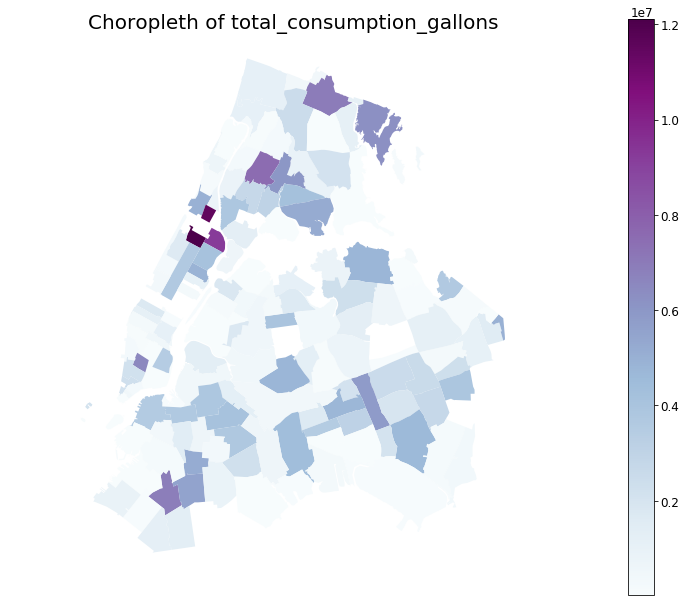

In [26]:
name = 'total_consumption_gallons'
ax = mapData.plot(column='{}'.format(name), cmap='BuPu', alpha=1)
vmin, vmax = min(mapData['{}'.format(name)].values), max(mapData['{}'.format(name)].values)
ax.axis('off')
ax.set_title('Choropleth of {}'.format(name), size=20)
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='BuPu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.savefig('boiler_total_consumption_gallons', dpi=300, transparent=True)
plt.show()